# Hair Segmentation 

In [1]:
import os
import numpy as np
import torch
import torch.utils.data as td
from PIL import Image
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
collab = False

2022-11-08 16:55:35.433282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 16:55:35.585554: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 16:55:36.177146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ndo001/miniconda3/envs/tf/lib/
2022-11-08 16:55:36.177218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

cuda


In [3]:
# a = torch.rand(4,4)
# print(a.cuda())


## Import dataset

In [2]:
# Dataset class
class HairDataset(td.Dataset):
    
    #mode should be 'Training' or 'Testing'
    def __init__(self, data_dir, image_size=(128, 128)):
        super(HairDataset, self).__init__()
        self.image_size = image_size
        self.images_dir = os.path.join(data_dir, 'imgs/Original')
        self.images = sorted(os.listdir(self.images_dir))
        self.targets_dir = os.path.join(data_dir, 'masks/GT')
        self.targets = sorted(os.listdir(self.targets_dir))        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])    
        img = np.asarray(Image.open(img_path).resize(self.image_size).convert('RGB'))/255
        target_path = os.path.join(self.targets_dir, self.targets[idx])    
        target = np.asarray(Image.open(target_path).resize(self.image_size).convert('RGB'))/255
        return img, target

Found 672 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.


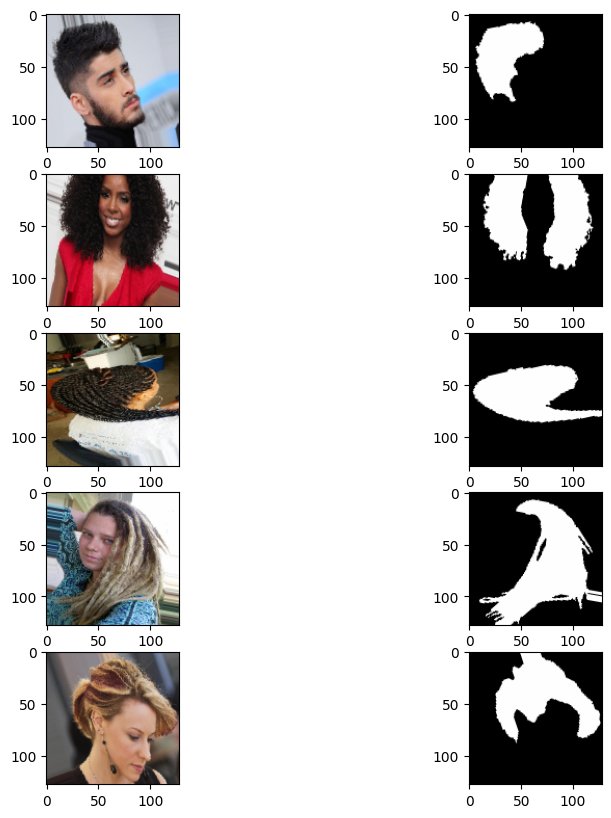

In [14]:
# define dataset dir path
if collab is False:
    root_dir = ''
else :
    root_dir = '/'
    #!unzip /Figaro1k.zip -d /


train_dir = os.path.join(root_dir, 'Figaro1k/Training')
test_dir = os.path.join(root_dir, 'Figaro1k/Testing')


# build training and testing set
train_set =  HairDataset(train_dir)
test_set =  HairDataset(test_dir)

# Seperate orignals and ground truth
def image_mask_separator(dataset):
    X = []
    y = []
    for image, mask in dataset:
        X.append(image)
        y.append(mask[:,:,0])
    return np.array(X), np.array(y)

X_train, y_train = image_mask_separator(train_set)
X_test, y_test = image_mask_separator(test_set)

# data augmentation
data_gen_args = dict(featurewise_center=True,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     validation_split=0.2,
                     shear_range=0.2,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 12345
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train[:,:,:,np.newaxis], augment=True, seed=seed)
image_train_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    target_size=(128,128),
    class_mode=None,
    batch_size=32,
    seed=seed,
    subset='training')

mask_train_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),
    target_size=(128, 128), 
    batch_size=32,
    class_mode=None,
    seed=seed,
    subset='training')

image_val_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    seed=seed,
    subset='validation')

mask_val_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    seed=seed,
    subset='validation')


# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

fig = plt.figure(figsize=(10,10))
i = 0
for generator in train_generator:
    plt.subplot(5,2,1+2*i)
    plt.imshow(generator[0][i].astype(int))
    plt.subplot(5,2,2+2*i)
    plt.imshow(generator[1][i].astype(int))
    i += 1
    if i % 5 == 0:
        break



## Create CNN

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [9]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

2022-11-08 16:59:54.778305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 16:59:54.780417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 16:59:54.780543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 16:59:54.780791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6a), conv4], axis=3) #Was conv5 instead of conv6a
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Train NN

In [15]:
#Create directory to save model and history
num_train = 0
while os.path.isdir(os.path.join(root_dir, 'training_{i}'.format(i=num_train))):
    num_train +=1
save_dir = os.path.join(root_dir, 'training_{i}'.format(i=num_train))
os.makedirs(save_dir)

#train model
epochs = 150
history = model.fit(train_generator,validation_data=val_generator,epochs=epochs,batch_size=64, steps_per_epoch=len(X_train) // 64)
model.save(os.path.join(save_dir, 'model.h5'))
np.save(os.path.join(save_dir, 'my_history.npy') ,history)
    

Epoch 1/150
13/13 [==============================] - ETA: 0s - loss: -1299.7196 - acc: 0.0000e+00

KeyboardInterrupt: 

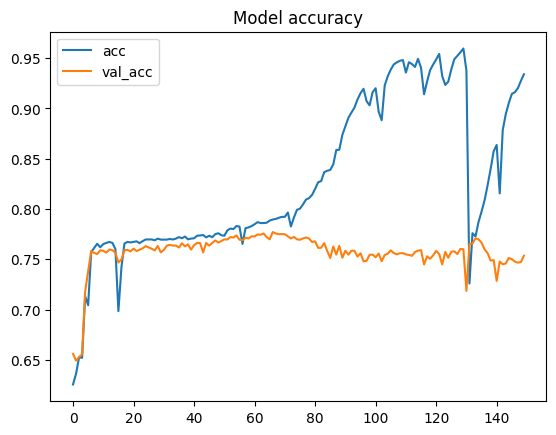

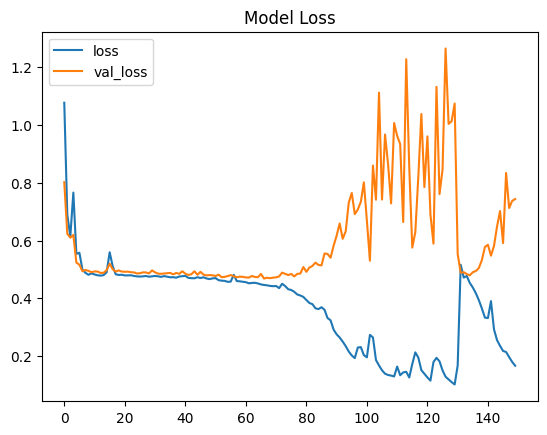

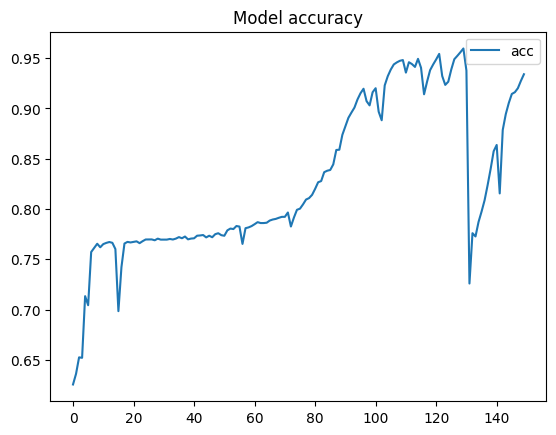

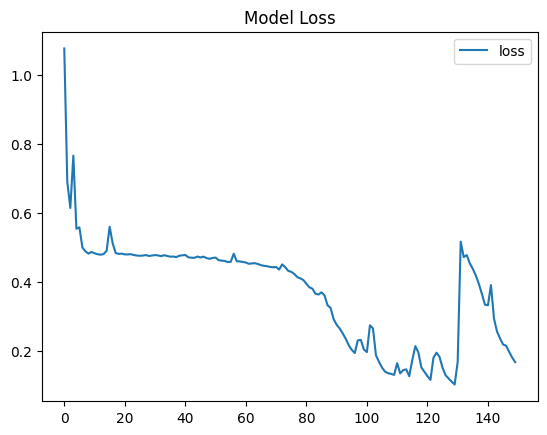

In [ ]:
#history=np.load('bce_50epochs_conv6a_history.npy',allow_pickle='TRUE').item()

# Must have been training during this execution
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Predict single image

(630, 128, 128, 3)
(1, 128, 128, 3)
1/1 [==============================] - 0s 24ms/step


(1, 128, 128, 1)
(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 26ms/step - loss: 0.4815 - acc: 0.8348
accuacy :  0.8348388671875


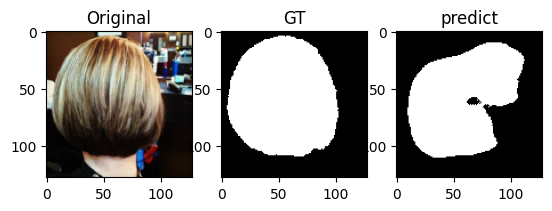

In [ ]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 30

print(X_test.shape)
print(X_test[idx][np.newaxis, :,:,:].shape)

pred = model.predict(X_test[idx][np.newaxis, :,:,:])

treshold = 0.5
print(pred.shape)

#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
pred_mask = np.repeat(pred_mask, 3, axis=3)
print(pred_mask[0].shape)

fig, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(1,3,1)
plt.imshow(X_test[idx])
plt.title("Original")
plt.subplot(1,3,2)
print(y_test[idx].shape)
plt.imshow(np.repeat(y_test[idx][:,:,np.newaxis],3, axis=2))
plt.title("GT")
plt.subplot(1,3,3)
plt.imshow(pred_mask[0])
plt.title("predict")

score = model.evaluate(X_test[idx][np.newaxis,:,:,:], y_test[idx][np.newaxis,:,:])
print("accuacy : ", score[1])

## Predict n first images

20/20 [==============================] - 1s 42ms/step


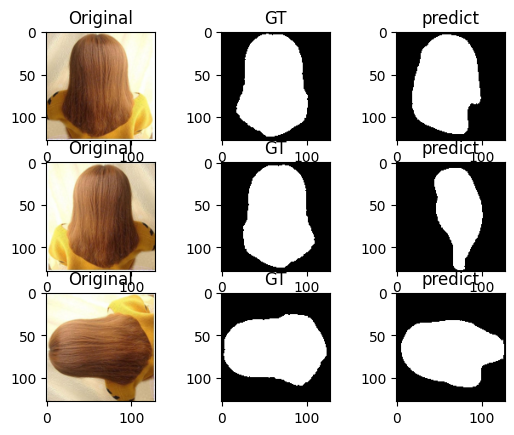

In [ ]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

n = 3
treshold = 0.5

pred = model.predict(X_test)
#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig, axes = plt.subplots(nrows=n, ncols=3)
for i in range(n*3):
    plt.subplot(3,3,i+1)
    if i % 3 == 0:
        plt.imshow(X_test[i//3])
        plt.title("Original")
    elif i % 3 == 1:
        plt.imshow(np.repeat(y_test[i//3][:,:,np.newaxis],3, axis=2))
        plt.title("GT")
    else:
        plt.imshow(pred_mask[i//3])
        plt.title("predict")

In [ ]:
#Evaluate model

score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print("accuracy on training set :", score_train[1])
print("accuracy on testing set :", score_test[1])

20/20 [==============================] - 1s 41ms/step - loss: 0.6000 - acc: 0.7940
accuracy on training set : 0.9125159978866577
accuracy on testing set : 0.7940180897712708
